In [1]:
from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_KV450
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import os

In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [3]:
path = '/home/zcapjru/PhD/Data/KV450/'

cats = [path+'KV450_G12_reweight_3x4x4_v2_good.cat', 
        path+'KV450_G23_reweight_3x4x4_v2_good.cat',
        path+'KV450_GS_reweight_3x4x4_v2_good.cat',
        path+'KV450_G15_reweight_3x4x4_v2_good.cat',
        path+'KV450_G9_reweight_3x4x4_v2_good.cat'
       ]
cats

['/home/zcapjru/PhD/Data/KV450/KV450_G12_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G23_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_GS_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G15_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G9_reweight_3x4x4_v2_good.cat']

In [4]:
KV_1_config = {'data_catalogs': cats , 
                'file_nz':path + 'REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_z0.1t0.3.asc',
          'zbin':1,
          'nside':nside, 
          'mask_name': 'mask_KV450_1'}

KV_2_config = {'data_catalogs': cats ,               
                'file_nz':path + 'REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_z0.3t0.5.asc',
          'zbin':2,
           'mask_name': 'mask_KV450_2',
          'nside':nside }

In [5]:
KV_1_maps = mapper_KV450.MapperKV450(KV_1_config)
#KV_2_maps = mapper_KV450.MapperKV450(KV_2_config)

loading lite cats
Catalogs loaded
z edges  [0.1, 0.3]
data concatenated
removed GAAP
Length of galaxies:  976840
Length of stars:  2265
Data binned


/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e1'] -= np.mean(self.cat_data[sel_gals]['bias_corrected_e1'])
/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e2'] -= np.mean(self.cat_data[sel_gals]['bias_corrected_e2'])
/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:105: SettingWithCopyWarning: 
A value is trying to be set on 

Additive biased removed
Multiplicative bias removed


/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e2'] /= 1 + m[self.zbin]


In [6]:
len(KV_1_maps.cat_data) #12 402 924 as opposed to  11 926 455

979105

In [7]:
KV_nz_1 = KV_1_maps.dndz
KV_z_1 = KV_nz_1[0]
KV_dNdz_1 = KV_nz_1[1]

In [22]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
ia = np.ones(120)*0.981
KV_shear = ccl.WeakLensingTracer(cosmo,  dndz=(KV_z_1,KV_dNdz_1), has_shear=True, ia_bias=(KV_z_1,ia), use_A_ia=True)
Theory_cl_s1s1 = ccl.angular_cl(cosmo, KV_shear, KV_shear, ell_arr) 

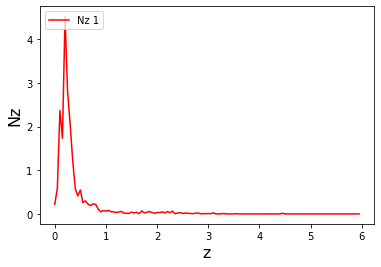

In [8]:
plt.plot(KV_z_1, KV_dNdz_1, 'r-', label='Nz 1')
#plt.plot(DES_z_1, DES_dNdz_1, 'g-', label='Nz 2')

plt.xlabel('z', fontsize=16)
plt.ylabel('Nz', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

In [9]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
KV_shear = ccl.CMBLensingTracer(cosmo, 0.6)
KV_theory = ccl.angular_cl(cosmo, KV_shear, KV_shear, ell_arr) 

In [10]:
KV_shear = KV_1_maps.get_signal_map(map_mode = 'shear')
KV_psf = KV_1_maps.get_signal_map(map_mode = 'PSF')
KV_stars = KV_1_maps.get_signal_map(map_mode = 'stars')

Calculating shear spin-2 field
Calculating PSF spin-2 field
Calculating star density spin-0 field


In [11]:
KV_galaxy_mask = KV_1_maps.get_mask(mask_mode='shear')
KV_galaxy_mask = KV_1_maps.get_mask(mask_mode='PSF')
KV_star_mask = KV_1_maps.get_mask(mask_mode='stars')

Using galaxies mask
Using galaxies mask
Using stars mask


/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

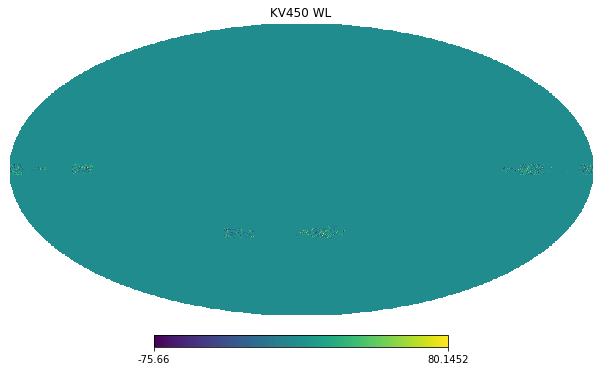

In [12]:
hp.visufunc.mollview(KV_shear[1], title= 'KV450 WL')

In [13]:
KV_shear_f =   KV_1_maps.get_nmt_field(mode='shear')
KV_psf_f =   KV_1_maps.get_nmt_field(mode='PSF')
KV_stars_f =   KV_1_maps.get_nmt_field(mode='stars')

Calculating shear spin-2 field
Using galaxies mask
Calculating PSF spin-2 field
Using galaxies mask
Calculating star density spin-0 field
Using stars mask


In [14]:
KV_w_s1s1 = nmt.NmtWorkspace()
KV_w_s1s1.compute_coupling_matrix(KV_shear_f, KV_shear_f, bands)

In [15]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [26]:
KV_nl_s1s1 = KV_1_maps.get_nl_coupled(nl_mode='shear')
#print(KV_nl_s1s1)
KV_nl_s1s1 = KV_w_s1s1.decouple_cell(KV_nl_s1s1)
cl_s1s1 = compute_cl(KV_shear_f, KV_shear_f, KV_w_s1s1)
#print(cl_s1s1, KV_nl_s1s1)
#cl_s1s1 = cl_s1s1 - KV_nl_s1s1

Calculating shear nl coupled


In [31]:
Theory_cl_s1s1

array([1.49839133e-09, 7.17608086e-10, 4.39447692e-10, 3.06252648e-10,
       2.27220706e-10, 1.75098273e-10, 1.39009174e-10, 1.12627982e-10,
       9.21755923e-11, 7.63795026e-11, 6.37424225e-11, 5.35535851e-11,
       4.51918906e-11, 3.82520690e-11, 3.24525201e-11, 2.75998773e-11,
       2.35186806e-11, 2.00708155e-11, 1.71490909e-11, 1.46566113e-11,
       1.25412605e-11, 1.07440739e-11, 9.21012969e-12, 7.89721595e-12])

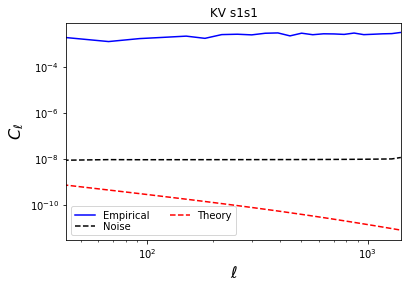

In [32]:
plt.plot(ell_arr, cl_s1s1[0], 'b-', label='Empirical')
plt.plot(ell_arr,KV_nl_s1s1[0], 'k--', label='Noise')
plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s1s1')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()